In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.formula.api import ols


In [2]:
dataset = pd.read_csv(r'../../data/processed/charity_main_cleaned.csv')
birm_disposal = pd.read_excel(r'../../data/raw/__Disposal( in period 09052025).xlsx')

C:\Users\User\AppData\Local\Temp\ipykernel_18408\2275096176.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(r'../../data/processed/charity_main_cleaned.csv')


In [3]:
category_map = {
    'classification_makes_grants_to_individuals': 'Grants_Related',
    'classification_makes_grants_to_organisations': 'Grants_Related',
    'classification_accommodation/housing': 'Housing_Infrastructure',
    'classification_provides_buildings/facilities/open_space': 'Housing_Infrastructure',
    'classification_education/training': 'Education_Research',
    'classification_sponsors_or_undertakes_research': 'Education_Research',
    'classification_children/young_people': 'Children_Youth',
    'classification_amateur_sport': 'Children_Youth',
    'classification_the_advancement_of_health_or_saving_of_lives': 'Health_Disability',
    'classification_disability': 'Health_Disability',
    'classification_people_with_disabilities': 'Health_Disability',
    'classification_human_rights/religious_or_racial_harmony/equality_or_diversity': 'Human_Rights_Advocacy',
    'classification_provides_advocacy/advice/information': 'Human_Rights_Advocacy',
    'classification_people_of_a_particular_ethnic_or_racial_origin': 'Human_Rights_Advocacy',
    'classification_religious_activities': 'Religion_Faith',
    'classification_acts_as_an_umbrella_or_resource_body': 'Religion_Faith',
    'classification_environment/conservation/heritage': 'Environment_Animals',
    'classification_animals': 'Environment_Animals',
    'classification_economic/community_development/employment': 'Economic_Social Development',
    'classification_general_charitable_purposes': 'Economic_Social_Development',
    'classification_provides_services': 'Economic_Social_Development',
    'classification_provides_human_resources': 'Economic_Social_Development',
    'classification_provides_other_finance': 'Economic_Social_Development',
    'classification_other_charitable_purposes': 'Economic_Social_Development',
    'classification_other_charities_or_voluntary_bodies': 'Economic_Social_Development',
    'classification_overseas_aid/famine_relief': 'Overseas_Famine_Relief',
    'classification_the_general_public/mankind': 'Other_Miscellaneous',
    'classification_other_defined_groups': 'Other_Miscellaneous',
    'classification_recreation': 'Other_Miscellaneous',
    'classification_elderly/old_people': 'Other_Miscellaneous',
    'classification_armed_forces/emergency_service_efficiency': 'Other_Miscellaneous',
    'classification_arts/culture/heritage/science': 'Other_Miscellaneous',
}
# Invert mapping: dummy_col -> group
dummy_to_group = {col: group for col, group in category_map.items()}

# Prepare a DataFrame to hold new dummy columns
group_dummies = pd.DataFrame(0, index=dataset.index, columns=sorted(set(dummy_to_group.values())))

# Assign each charity to the first matching group only (no double count)
for idx, row in dataset.iterrows():
    for col, group in dummy_to_group.items():
        if col in dataset.columns and row[col] == 1:
            group_dummies.at[idx, group] = 1
            break  # stop after first match
dataset = pd.concat([dataset, group_dummies], axis=1)
category_drop = {
    'classification_makes_grants_to_individuals',
    'classification_makes_grants_to_organisations',
    'classification_accommodation/housing',
    'classification_provides_buildings/facilities/open_space',
    'classification_education/training',
    'classification_sponsors_or_undertakes_research',
    'classification_children/young_people',
    'classification_amateur_sport',
    'classification_the_advancement_of_health_or_saving_of_lives',
    'classification_disability',
    'classification_people_with_disabilities',
    'classification_human_rights/religious_or_racial_harmony/equality_or_diversity',
    'classification_provides_advocacy/advice/information',
    'classification_people_of_a_particular_ethnic_or_racial_origin',
    'classification_religious_activities',
    'classification_acts_as_an_umbrella_or_resource_body',
    'classification_environment/conservation/heritage',
    'classification_animals',
    'classification_economic/community_development/employment',
    'classification_general_charitable_purposes',
    'classification_provides_services',
    'classification_provides_human_resources',
    'classification_provides_other_finance',
    'classification_other_charitable_purposes',
    'classification_other_charities_or_voluntary_bodies',
    'classification_overseas_aid/famine_relief',
    'classification_the_general_public/mankind',
    'classification_other_defined_groups',
    'classification_recreation',
    'classification_elderly/old_people',
    'classification_armed_forces/emergency_service_efficiency',
    'classification_arts/culture/heritage/science'
}
dataset = dataset.drop(columns=category_drop, errors='ignore')

In [4]:
df = dataset[dataset['local_authority'] == 'Birmingham']

In [5]:
birm_disposal.columns

Index(['IPMSREF', 'LLPGREF', 'TYPEPROP', 'ADDRPROP', 'TOWN', 'COUNTY',
       'POSTCODE', 'WARD', 'CONSTIT', 'DISPLDATE', 'DEEDCONS', 'TYPECONSD',
       'INTEREST'],
      dtype='object')

In [21]:
birm_disposal['TYPECONSD'].unique()

array(['MONETARY', 'PEPPERCORN', nan], dtype=object)

In [6]:
df.columns

Index(['registered_charity_number', 'charity_name', 'postcode',
       'charity_status', 'charity_type', 'date_of_registration',
       'date_of_removal', 'latest_income', 'charity_activities',
       'charity_has_land', 'companyNumber', 'local_authority', 'size_category',
       'classification_description', 'registration_year', 'removal_year',
       'registration_month', 'removal_month', 'registration_fy', 'removal_fy',
       'classification_other_charitable_activities',
       'classification_the_prevention_or_relief_of_poverty', 'Children_Youth',
       'Economic_Social Development', 'Economic_Social_Development',
       'Education_Research', 'Environment_Animals', 'Grants_Related',
       'Health_Disability', 'Housing_Infrastructure', 'Human_Rights_Advocacy',
       'Other_Miscellaneous', 'Overseas_Famine_Relief', 'Religion_Faith'],
      dtype='object')

In [7]:
# --- Parameters ---
treatment_date = pd.to_datetime("2023-09-05")  # your treatment date
birm_disposal['DISPLDATE'] = pd.to_datetime(birm_disposal['DISPLDATE'].astype(str), format='%Y%m%d', errors='coerce')


In [8]:
monthly_disposals = (
    birm_disposal['DISPLDATE']
    .dt.to_period('M')
    .value_counts()
    .sort_index()
    .rename('count')
    .to_frame()
)
monthly_disposals.index = monthly_disposals.index.to_timestamp()
monthly_disposals.index.name = 'month'
monthly_disposals = monthly_disposals.asfreq('MS', fill_value=0)

# Step 2: Create pre/post indicator
monthly_disposals['post'] = (monthly_disposals.index >= treatment_date).astype(int)

# Step 3: Create lead and lag indicators (3 months before and after)
monthly_disposals['lead_3'] = (monthly_disposals.index < treatment_date - pd.DateOffset(months=2)).astype(int)
monthly_disposals['lead_2'] = ((monthly_disposals.index >= treatment_date - pd.DateOffset(months=2)) & 
                               (monthly_disposals.index < treatment_date - pd.DateOffset(months=1))).astype(int)
monthly_disposals['lead_1'] = ((monthly_disposals.index >= treatment_date - pd.DateOffset(months=1)) & 
                               (monthly_disposals.index < treatment_date)).astype(int)
monthly_disposals['lag_0'] = (monthly_disposals.index == treatment_date.replace(day=1)).astype(int)
monthly_disposals['lag_1'] = ((monthly_disposals.index > treatment_date) & 
                              (monthly_disposals.index <= treatment_date + pd.DateOffset(months=1))).astype(int)
monthly_disposals['lag_2'] = ((monthly_disposals.index > treatment_date + pd.DateOffset(months=1)) & 
                              (monthly_disposals.index <= treatment_date + pd.DateOffset(months=2))).astype(int)
monthly_disposals['lag_3'] = (monthly_disposals.index > treatment_date + pd.DateOffset(months=2)).astype(int)

# Step 4: Run regression with leads/lags
formula = 'count ~ lead_3 + lead_2 + lead_1 + lag_0 + lag_1 + lag_2 + lag_3'
model = ols(formula, data=monthly_disposals).fit()
model_summary = model.summary()

model_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     2.820
Date:                Wed, 02 Jul 2025   Prob (F-statistic):             0.0437
Time:                        21:12:19   Log-Likelihood:                -98.843
No. Observations:                  26   AIC:                             209.7
Df Residuals:                      20   BIC:                             217.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     38.7735      3.584     10.820      0.000      31.298      46.249
lead_3        15.9765      6.265      2.550      0.019       2.908      29.045
lead_2       -11.7735     10.885     -1.082      0.292     -34.479      10.932
lead_1         4.1132      5.957      0.690      0.498      -8.314      16.540
lag_0          4.1132      5.957      0.690      0.498      -8.314      16.540
lag_1         28.2265     10.885      2.593      0.017       5.521      50.932
lag_2          5.2265     10.885      0.480      0.636     -17.479      27.932
lag_3         -2.9957      4.326     -0.693      0.497     -12.019       6.027
==============================================================================
Omnibus:                       11.960   Durbin-Watson:                   1.350
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               11.297
Skew:                          -1.191   Prob(JB):                      0.00352
Kurtosis:                       5.179   Cond. No.                     4.29e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.22e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

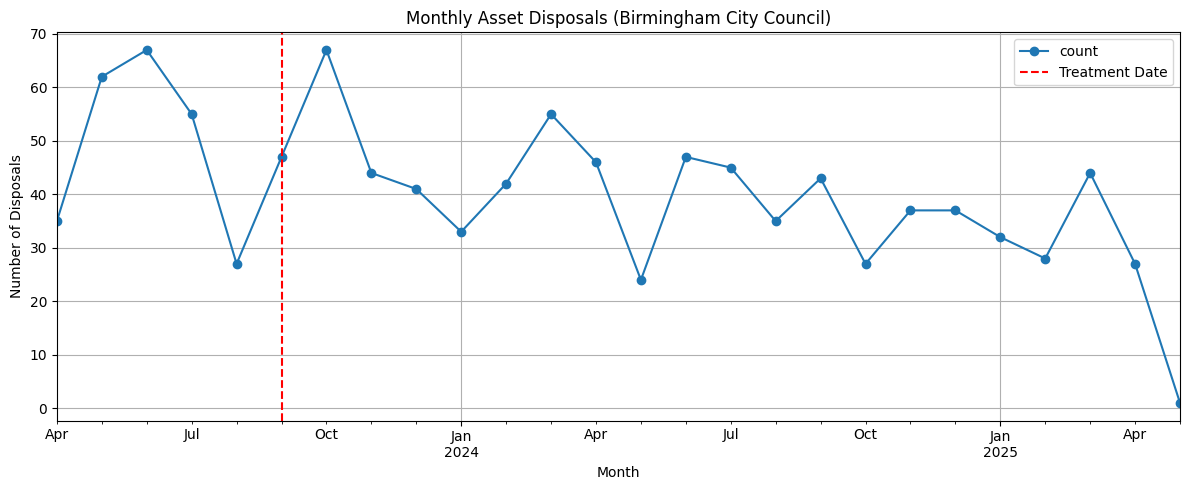

In [9]:
import matplotlib.pyplot as plt

# Assume daily_disposals_monthly is already grouped and includes 'post' indicator
# Plot line graph of monthly disposal count

plt.figure(figsize=(12, 5))
monthly_disposals['count'].plot(marker='o', linestyle='-')
plt.axvline(treatment_date, color='red', linestyle='--', label='Treatment Date')
plt.title('Monthly Asset Disposals (Birmingham City Council)')
plt.xlabel('Month')
plt.ylabel('Number of Disposals')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


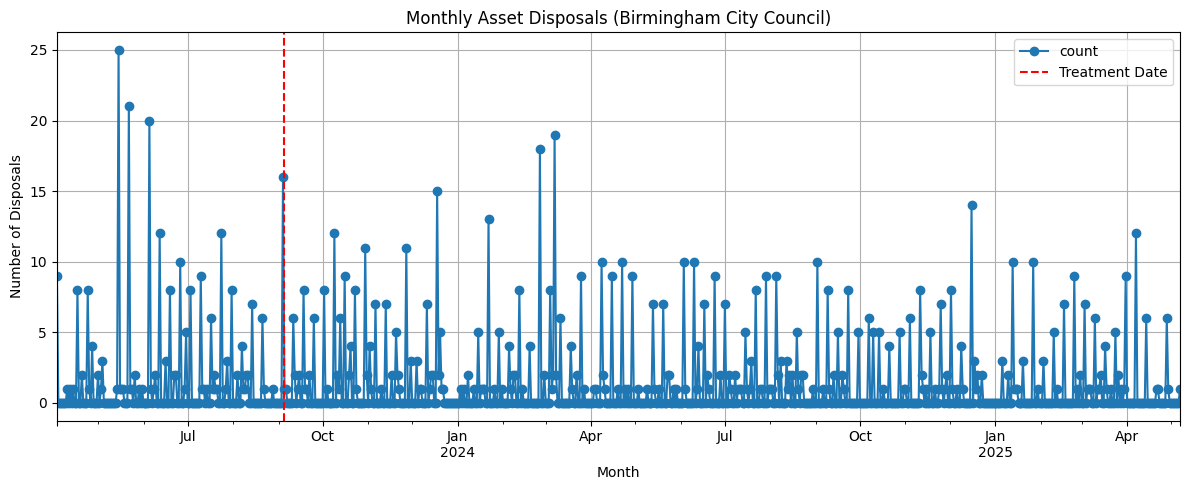

In [20]:
plt.figure(figsize=(12, 5))
daily_disposals['count'].plot(marker='o', linestyle='-')
plt.axvline(treatment_date, color='red', linestyle='--', label='Treatment Date')
plt.title('Monthly Asset Disposals (Birmingham City Council)')
plt.xlabel('Month')
plt.ylabel('Number of Disposals')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
monthly_disposals['time'] = range(len(monthly_disposals))
monthly_disposals['post_time'] = monthly_disposals['time'] * monthly_disposals['post']

In [11]:
import statsmodels.api as sm

X = sm.add_constant(monthly_disposals[['time', 'post', 'post_time']])
y = monthly_disposals['count']
model = sm.OLS(y, X).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     4.496
Date:                Wed, 02 Jul 2025   Prob (F-statistic):             0.0132
Time:                        21:12:20   Log-Likelihood:                -99.564
No. Observations:                  26   AIC:                             207.1
Df Residuals:                      22   BIC:                             212.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.9048      8.764      6.037      0.000      34.729      71.080
time          -1.6286      2.895     -0.563      0.579      -7.632       4.375
post           7.0464     11.710      0.602      0.553     -17.238      31.330
post_time      0.1962      2.932      0.067      0.947      -5.885       6.278
==============================================================================
Omnibus:                        1.486   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.476   Jarque-Bera (JB):                1.354
Skew:                          -0.454   Prob(JB):                        0.508
Kurtosis:                       2.347   Cond. No.                         122.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
from statsmodels.formula.api import ols
import numpy as np

# Step 1: Define breakpoint
breakpoint = '2023-09-01'
pre = monthly_disposals[monthly_disposals.index < breakpoint]
post = monthly_disposals[monthly_disposals.index >= breakpoint]

# Step 2: Run regressions
model_full = ols('count ~ time', data=monthly_disposals).fit()
model_pre = ols('count ~ time', data=pre).fit()
model_post = ols('count ~ time', data=post).fit()

# Step 3: Chow test statistic
SSR_full = sum(model_full.resid ** 2)
SSR_pre = sum(model_pre.resid ** 2)
SSR_post = sum(model_post.resid ** 2)

k = model_full.df_model + 1  # number of parameters
n_pre = len(pre)
n_post = len(post)

numerator = (SSR_full - (SSR_pre + SSR_post)) / k
denominator = (SSR_pre + SSR_post) / (n_pre + n_post - 2 * k)
chow_stat = numerator / denominator

from scipy.stats import f
p_value = 1 - f.cdf(chow_stat, k, n_pre + n_post - 2 * k)

print(f'Chow Test Statistic: {chow_stat:.4f}')
print(f'P-value: {p_value:.4f}')


Chow Test Statistic: 0.3666
P-value: 0.6972


In [13]:
daily_disposals = birm_disposal['DISPLDATE'].value_counts().sort_index().rename('count').to_frame()
daily_disposals.index.name = 'date'
daily_disposals = daily_disposals.asfreq('D', fill_value=0)
break_date = pd.Timestamp("2023-09-05")

pre = daily_disposals[daily_disposals.index < break_date]
post = daily_disposals[daily_disposals.index >= break_date]

# Add a time trend if needed
pre = pre.copy()
post = post.copy()
pre['time'] = range(len(pre))
post['time'] = range(len(post))
from statsmodels.api import OLS, add_constant
from scipy.stats import f

# Fit models
X_pre = add_constant(pre['time'])
X_post = add_constant(post['time'])
y_pre = pre['count']
y_post = post['count']

model_full = OLS(daily_disposals['count'], add_constant(range(len(daily_disposals)))).fit()
model_pre = OLS(y_pre, X_pre).fit()
model_post = OLS(y_post, X_post).fit()

# Chow test calculation
RSS_pooled = sum(model_full.resid**2)
RSS_pre = sum(model_pre.resid**2)
RSS_post = sum(model_post.resid**2)

k = X_pre.shape[1]  # number of parameters
n_pre = len(y_pre)
n_post = len(y_post)

numerator = (RSS_pooled - (RSS_pre + RSS_post)) / k
denominator = (RSS_pre + RSS_post) / (n_pre + n_post - 2 * k)
chow_stat = numerator / denominator
p_value = 1 - f.cdf(chow_stat, k, n_pre + n_post - 2 * k)

print(f"Chow Test Statistic: {chow_stat:.4f}")
print(f"P-value: {p_value:.4f}")


Chow Test Statistic: 0.0049
P-value: 0.9951


                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                 -0.058
Method:                 Least Squares   F-statistic:                    0.6248
Date:                Wed, 02 Jul 2025   Prob (F-statistic):              0.856
Time:                        21:12:45   Log-Likelihood:                -334.26
No. Observations:                 111   AIC:                             702.5
Df Residuals:                      94   BIC:                             748.6
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.0947      0.548     16.595      0.0

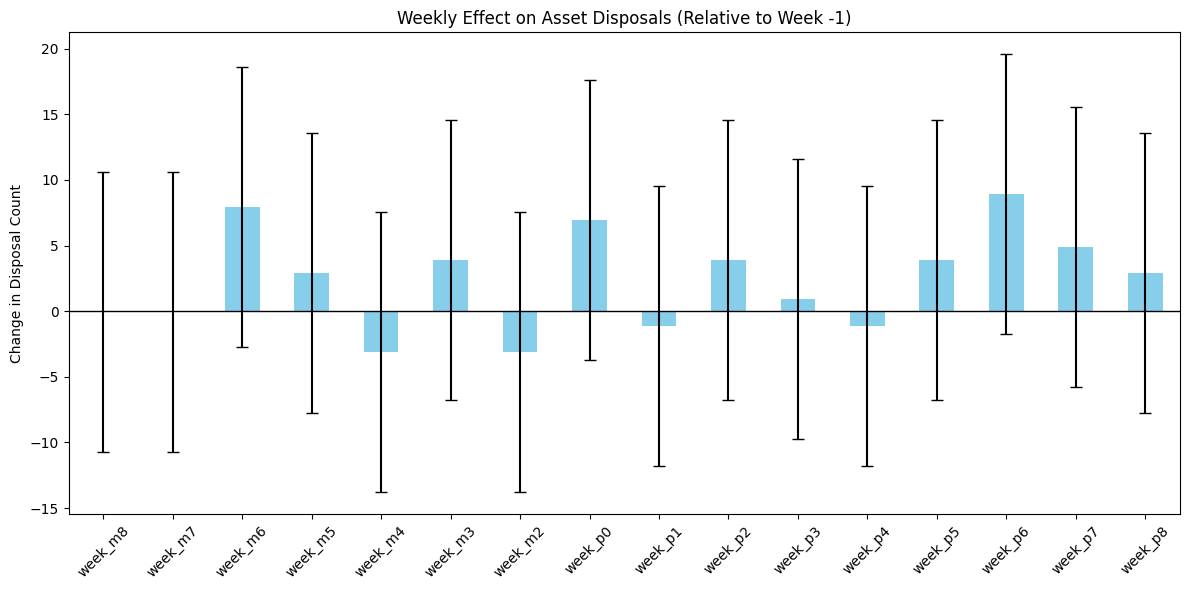

In [16]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# --- Step 1: Aggregate to weekly disposal count ---
birm_disposal['DISPLDATE'] = pd.to_datetime(birm_disposal['DISPLDATE'])
weekly_disposals = (
    birm_disposal.set_index('DISPLDATE')
    .resample('W-MON')  # Weeks starting Monday
    .size()
    .rename('count')
    .to_frame()
)

# --- Step 2: Calculate week relative to treatment date ---
treatment_date = pd.Timestamp("2023-09-05")
reference_monday = treatment_date - pd.DateOffset(days=treatment_date.weekday())  # align to start of week

weekly_disposals['relative_week'] = (
    (weekly_disposals.index - reference_monday) / pd.Timedelta(weeks=1)
).round().astype(int)

# --- Step 3: Create lead/lag dummies with safe names ---
window = 8  # e.g. ±8 weeks
for i in range(-window, window + 1):
    var_name = f"week_p{i}" if i >= 0 else f"week_m{-i}"
    weekly_disposals[var_name] = (weekly_disposals['relative_week'] == i).astype(int)

# --- Step 4: Drop the baseline (e.g. week before treatment, i = -1) ---
baseline_var = "week_m1"
event_vars = [col for col in weekly_disposals.columns if col.startswith("week_") and col != baseline_var]

# --- Step 5: Run regression ---
formula = "count ~ " + " + ".join(event_vars)
model = smf.ols(formula, data=weekly_disposals).fit()
print(model.summary())

# --- Step 6: Plot coefficients ---
coefs = model.params[event_vars]
conf_int = model.conf_int().loc[event_vars]
errors = coefs - conf_int[0]  # symmetric error bars

plt.figure(figsize=(12, 6))
coefs.plot(kind='bar', yerr=errors, capsize=4, color='skyblue')
plt.axhline(0, color='black', linewidth=1)
plt.title("Weekly Effect on Asset Disposals (Relative to Week -1)")
plt.ylabel("Change in Disposal Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [19]:
# Step 1: Create first difference of disposal counts
weekly_disposals['count_diff'] = weekly_disposals['count'].diff()

# Step 2: Drop first row (now NaN after differencing)
weekly_disposals = weekly_disposals.dropna(subset=['count_diff'])

# Step 3: Run the same event-study model on the differenced series
event_vars = [f"week_{i:+d}".replace("+", "p").replace("-", "m") for i in range(-8, 9) if i != -1]
formula = "count_diff ~ " + " + ".join(event_vars)

model = smf.ols(formula=formula, data=weekly_disposals).fit()
model.summary()


C:\Users\User\AppData\Local\Temp\ipykernel_18408\1991093272.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekly_disposals['count_diff'] = weekly_disposals['count'].diff()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             count_diff   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                 -0.039
Method:                 Least Squares   F-statistic:                    0.7462
Date:                Wed, 02 Jul 2025   Prob (F-statistic):              0.740
Time:                        21:13:04   Log-Likelihood:                -356.99
No. Observations:                 108   AIC:                             748.0
Df Residuals:                      91   BIC:                             793.6
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1196      0.749     -0.160      0.874      -1.608       1.369
week_m8       -4.8804      7.225     -0.675      0.501     -19.233       9.472
week_m7        0.1196      7.225      0.017      0.987     -14.233      14.472
week_m6        8.1196      7.225      1.124      0.264      -6.233      22.472
week_m5       -4.8804      7.225     -0.675      0.501     -19.233       9.472
week_m4       -5.8804      7.225     -0.814      0.418     -20.233       8.472
week_m3        7.1196      7.225      0.985      0.327      -7.233      21.472
week_m2       -6.8804      7.225     -0.952      0.343     -21.233       7.472
week_p0       14.1196      7.225      1.954      0.054      -0.233      28.472
week_p1       -7.8804      7.225     -1.091      0.278     -22.233       6.472
week_p2        5.1196      7.225      0.709      0.480      -9.233      19.472
week_p3       -2.8804      7.225     -0.399      0.691     -17.233      11.472
week_p4       -1.8804      7.225     -0.260      0.795     -16.233      12.472
week_p5        5.1196      7.225      0.709      0.480      -9.233      19.472
week_p6        5.1196      7.225      0.709      0.480      -9.233      19.472
week_p7       -3.8804      7.225     -0.537      0.593     -18.233      10.472
week_p8       -1.8804      7.225     -0.260      0.795     -16.233      12.472
==============================================================================
Omnibus:                       12.858   Durbin-Watson:                   3.024
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               41.710
Skew:                           0.005   Prob(JB):                     8.77e-10
Kurtosis:                       6.044   Cond. No.                         11.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

                            OLS Regression Results                            
Dep. Variable:              log_count   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                 -0.087
Method:                 Least Squares   F-statistic:                    0.4480
Date:                Wed, 02 Jul 2025   Prob (F-statistic):              0.964
Time:                        21:30:31   Log-Likelihood:                -99.831
No. Observations:                 111   AIC:                             233.7
Df Residuals:                      94   BIC:                             279.7
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1463      0.066     32.367      0.0

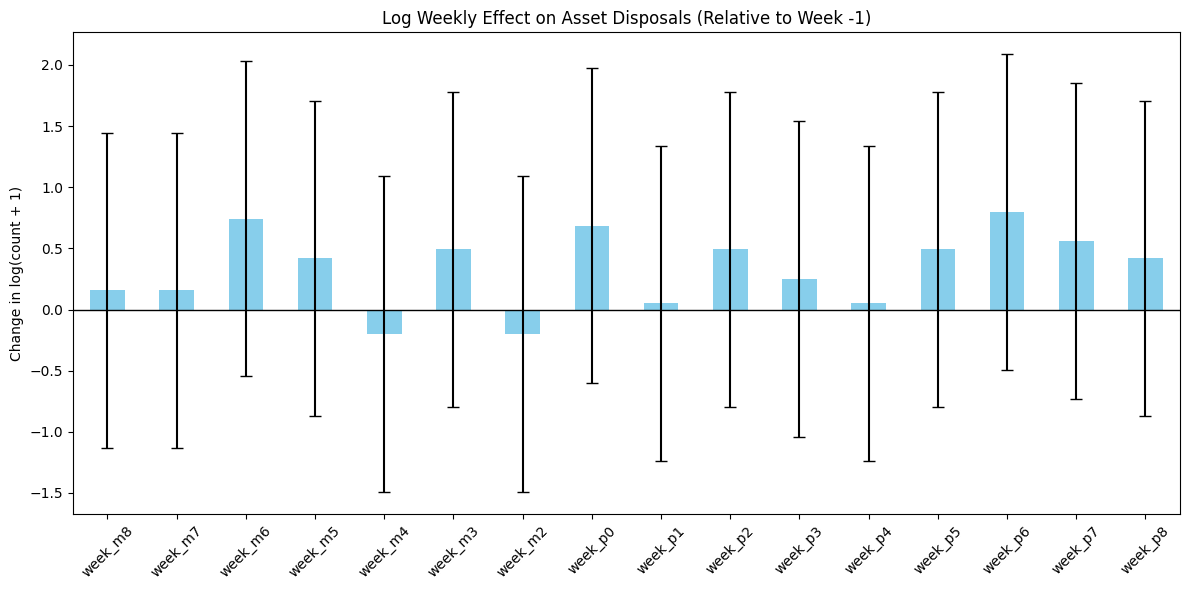

In [22]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# --- Step 1: Aggregate to weekly disposal count ---
birm_disposal['DISPLDATE'] = pd.to_datetime(birm_disposal['DISPLDATE'])
weekly_disposals = (
    birm_disposal.set_index('DISPLDATE')
    .resample('W-MON')  # Weeks starting Monday
    .size()
    .rename('count')
    .to_frame()
)

# --- Step 1.1: Log-transform the count (add 1 to avoid log(0)) ---
weekly_disposals['log_count'] = np.log1p(weekly_disposals['count'])

# --- Step 2: Calculate week relative to treatment date ---
treatment_date = pd.Timestamp("2023-09-05")
reference_monday = treatment_date - pd.DateOffset(days=treatment_date.weekday())

weekly_disposals['relative_week'] = (
    (weekly_disposals.index - reference_monday) / pd.Timedelta(weeks=1)
).round().astype(int)

# --- Step 3: Create lead/lag dummies with safe names ---
window = 8
for i in range(-window, window + 1):
    var_name = f"week_p{i}" if i >= 0 else f"week_m{-i}"
    weekly_disposals[var_name] = (weekly_disposals['relative_week'] == i).astype(int)

# --- Step 4: Drop baseline week (-1) ---
baseline_var = "week_m1"
event_vars = [col for col in weekly_disposals.columns if col.startswith("week_") and col != baseline_var]

# --- Step 5: Run regression using log_count as outcome ---
formula = "log_count ~ " + " + ".join(event_vars)
model = smf.ols(formula, data=weekly_disposals).fit()
print(model.summary())

# --- Step 6: Plot coefficients ---
coefs = model.params[event_vars]
conf_int = model.conf_int().loc[event_vars]
errors = coefs - conf_int[0]

plt.figure(figsize=(12, 6))
coefs.plot(kind='bar', yerr=errors, capsize=4, color='skyblue')
plt.axhline(0, color='black', linewidth=1)
plt.title("Log Weekly Effect on Asset Disposals (Relative to Week -1)")
plt.ylabel("Change in log(count + 1)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
